# OpenPIV examples that you can execute in your browser

Thanks to the great service of mybinder.org

## Import what is necessary from OpenPIV

In [1]:
try:
    import openpiv
except ImportError:
    %pip install openpiv

In [2]:
from openpiv import tools, validation, filters, scaling, pyprocess
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
# from ipywidgets import interact_manual, interactive, fixed, IntSlider, HBox, VBox, Layout

## Read a pair of PIV images

In [3]:
frame_a  = tools.imread( 'exp1_001_b.bmp' )
frame_b  = tools.imread( 'exp1_001_c.bmp' )

## Show them using matplotlib

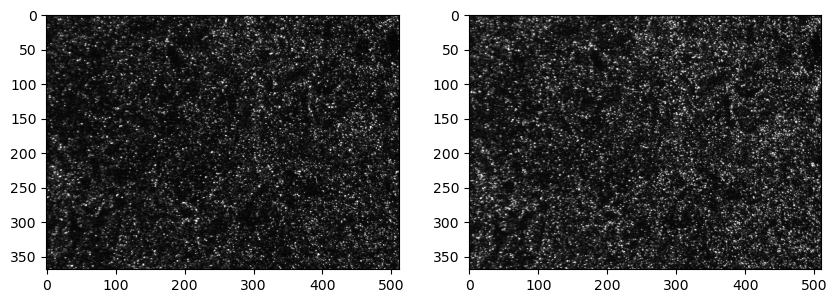

In [4]:
fig,ax = plt.subplots(1,2,figsize=(10,8))
ax[0].imshow(frame_a,cmap=plt.cm.gray)
ax[1].imshow(frame_b,cmap=plt.cm.gray)


## Define the PIV analysis parameters

1. Size of the interrogation window in frame A (winsize), 
2. Size of the search window in frame B (searchsize is larger or equal to winsize), 
3. overlap between the neighbouring windows (overlap), 
4. time interval of the PIV recording ($\Delta t$)
5. type of the peak quality (signal-to-noise ratio)

In [5]:
winsize = 24 # pixels
searchsize = 32  # pixels, search in image B
overlap = 12 # pixels
dt = 0.02 # sec

## Run the OpenPIV (fast code, precompiled in Cython)

In [6]:
u, v, sig2noise = pyprocess.extended_search_area_piv( frame_a.astype(np.int32), frame_b.astype(np.int32), 
                                                     window_size=winsize, overlap=overlap, dt=dt, 
                                                     search_area_size=searchsize, sig2noise_method='peak2peak' )

## Get a list of coordinates for the vector field

In [7]:
x, y = pyprocess.get_coordinates( image_size=frame_a.shape, search_area_size=searchsize, overlap=overlap )

## Clean the peaks that are below a quality threshold

In [8]:
mask = validation.sig2noise_val(sig2noise, threshold = 1.05 )

## Replace those that are masked as bad vectors with local interpolation

In [9]:
u, v = filters.replace_outliers( u, v, mask, method='localmean', max_iter=10, kernel_size=2)

## Scale the results from pix/dt to mm/sec

In [10]:
x, y, u, v = scaling.uniform(x, y, u, v, scaling_factor = 96.52 )

## store the result in a text file

In [11]:
tools.save('exp1_001.txt', x, y, u, v, mask, mask)

## plot the data stored in the text file

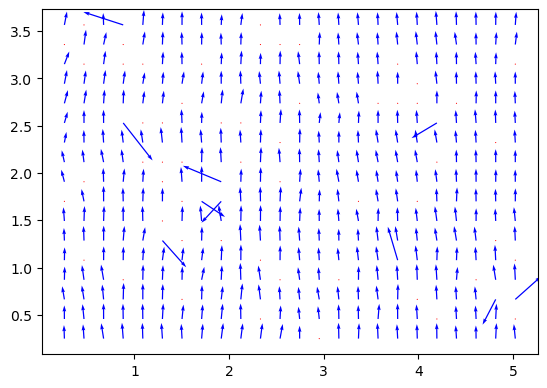

(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

In [12]:
tools.display_vector_field('exp1_001.txt', scale=100, width=0.0025)

# Another example
## Use any pair of images that you can access via URL
For instance we can use images from PIV Challenge http://www.pivchallenge.org/

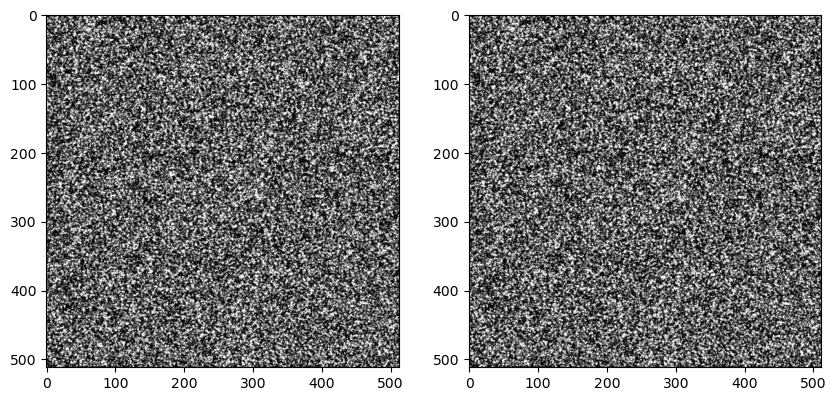

In [13]:
frame_a = tools.imread('http://www.pivchallenge.org/pub/B/B001_1.tif')
frame_b = tools.imread('http://www.pivchallenge.org/pub/B/B001_2.tif')
fig,ax = plt.subplots(1,2,figsize=(10,8))
ax[0].imshow(frame_a,cmap=plt.cm.gray)
ax[1].imshow(frame_b,cmap=plt.cm.gray)

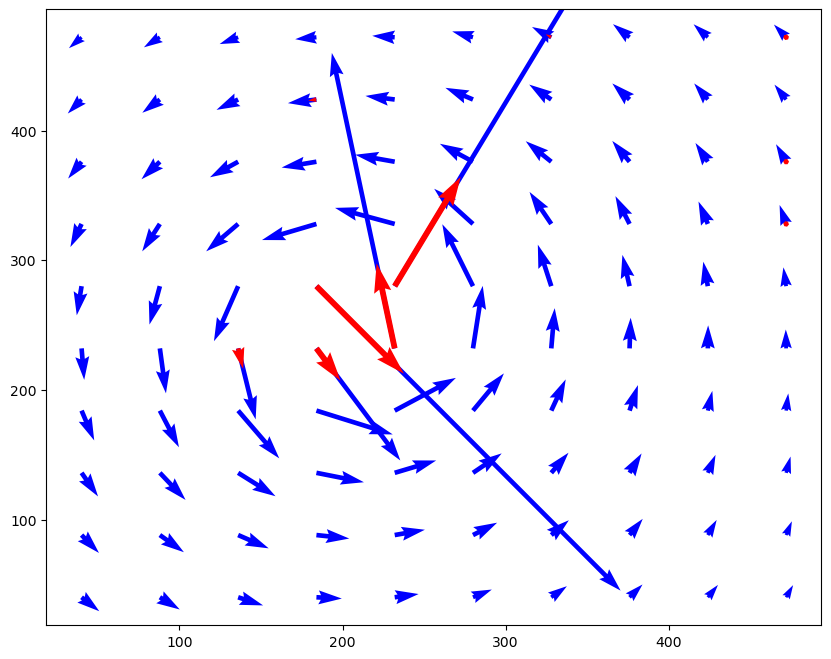

In [14]:
winsize = 32 # pixels
searchsize = 64  # pixels, search in image B
overlap = 16 # pixels
dt = 1.0 # sec
u1, v1, sig2noise = pyprocess.extended_search_area_piv( frame_a.astype(np.int32), 
                                                       frame_b.astype(np.int32), 
                                                       window_size=winsize, 
                                                       overlap=overlap, 
                                                       dt=dt, 
                                                       search_area_size=searchsize, 
                                                       sig2noise_method='peak2peak' )
x, y = pyprocess.get_coordinates( image_size=frame_a.shape, 
                                 search_area_size=searchsize, 
                                 overlap=overlap )
mask = validation.sig2noise_val(sig2noise, threshold = 1.05 )

plt.figure(figsize=(10,8))
plt.quiver(x,y,u1,v1,color='b')
plt.quiver(x[mask],y[mask],u1[mask],v1[mask],color='r')

# How to use IpyWidgets to get an interactive GUI
## Import ipywidgets 
read more about those on https://ipywidgets.readthedocs.io/en/stable/index.html

In [15]:
from ipywidgets import interact, interactive, fixed, interact_manual, Layout, VBox, HBox

In [16]:
def func(winsize,overlap,searchsize,s2n_method,s2n_threshold):
    if overlap >= winsize:
        overlap -= 1
        
    u, v, sig2noise = pyprocess.extended_search_area_piv(frame_a.astype(np.int32), frame_b.astype(np.int32), window_size=winsize, overlap=overlap, dt=dt, search_area_size=searchsize, sig2noise_method=s2n_method )
    x, y = pyprocess.get_coordinates( image_size=frame_a.shape, search_area_size=searchsize, overlap=overlap )
    mask = validation.sig2noise_val(sig2noise, threshold = s2n_threshold )
    u, v = filters.replace_outliers( u, v, mask, method='localmean', max_iter=10, kernel_size=2)
    plt.figure(figsize=(10,8))
    plt.quiver(x,y,u,v,color='b')
    plt.quiver(x[mask],y[mask],u[mask],v[mask],color='r');

## Press Run interact to get PIV output for the values in the list 

In [19]:
def run():
    w = interactive(func,winsize=[32,8,16,64,128],
                overlap=[16,8,32,64], 
                searchsize=[64,16,32,128,256],
                s2n_method=['peak2peak','peak2mean'],
                s2n_threshold=(1,2,.1));
    box_layout = Layout(display='flex', flex_flow='row', 
                        justify_content='space-between', 
                        align_items='flex-start')
    par = VBox([_ for _ in w.children[:-1]])
    display(HBox([w.children[-1],par], layout=box_layout))
    
run()

In [20]:
run()